Classification metrics:

Confusion matrix, ROC, AUC

Calibration:

Reliability plot / calibration curve

Brier score

Binning PD vs observed default rate

Different metrics for different use cases:

PD model: calibration + ranking (AUC)

VaR model: backtesting exceptions, not just RMSE

# Credit Default Prediction: EDA and Baseline Modelling

This notebook explores a loan default dataset (`Loan_Default.csv`) with the goal of:

- Understanding what drives **loan default**.
- Building simple **baseline classification models** for Probability of Default (PD).
- Comparing models using **credit-relevant metrics** such as recall and ROC–AUC.

The notebook is structured as:

1. Data loading and initial inspection  
2. Data quality checks and missing values  
3. Exploratory Data Analysis (EDA)  
4. Preprocessing and feature engineering  
5. Baseline classification models  
6. Evaluation and comparison  
7. Discussion and next steps

This is intended as a starting point for a more complete **credit model validation** workflow.


In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Plot style
plt.style.use("default")
sns.set_theme()


## 1. Data Loading and Initial Inspection
We first load the raw CSV file and take a quick look at its structure:

- Number of rows and columns  
- Column names and data types  
- Example rows  
- Basic summary statistics for numeric variables


In [2]:
# Update the path if needed
data_path = "Loan_Default.csv"

loan_data = pd.read_csv(data_path)

print("Shape of dataset:", loan_data.shape)
print("\nColumns:\n", loan_data.columns.tolist())

display(loan_data.head())
display(loan_data.info())
display(loan_data.describe(include="all").T)

Shape of dataset: (148670, 34)

Columns:
 ['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status', 'dtir1']


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,148670.0,NaN,NaN,NaN,99224.5,42917.476598,24890.0,62057.25,99224.5,136391.75,173559.0
year,148670.0,NaN,NaN,NaN,2019.0,0.0,2019.0,2019.0,2019.0,2019.0,2019.0
loan_limit,145326,2,cf,135348,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,148670,4,Male,42346,NaN,NaN,NaN,NaN,NaN,NaN,NaN
approv_in_adv,147762,2,nopre,124621,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_type,148670,3,type1,113173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_purpose,148536,4,p3,55934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit_Worthiness,148670,2,l1,142344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
open_credit,148670,2,nopc,148114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_or_commercial,148670,2,nob/c,127908,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Quality and Missing Values

Before modelling, we need to understand data quality:

- How many missing values per column?
- Which features are most affected?
- Are there obviously useless columns (e.g. free text IDs)?

We compute both the **absolute** and **percentage** of missing values.


In [3]:
# Absolute and percentage missing values
missing_counts = loan_data.isnull().sum()
missing_percent = (missing_counts / len(loan_data)) * 100

missing_df = (
    pd.concat([missing_counts, missing_percent], axis=1)
    .rename(columns={0: "missing_count", 1: "missing_percent"})
    .sort_values("missing_percent", ascending=False)
)

missing_df[missing_df["missing_count"] > 0]

,missing_count,missing_percent
Upfront_charges,39642,26.664425
Interest_rate_spread,36639,24.644515
rate_of_interest,36439,24.509989
dtir1,24121,16.224524
LTV,15098,10.155378
property_value,15098,10.155378
income,9150,6.154571
loan_limit,3344,2.249277
approv_in_adv,908,0.610749
submission_of_application,200,0.134526


We can decide on a strategy later, but from this table we see:

- Some financial variables (e.g. **interest rates, upfront charges, dtir1, LTV**) may have substantial missingness.
- Some categorical variables also have small amounts of missing data.

For this baseline notebook, we will use **simple imputation** (mean for numeric, mode for categorical). For a real model validation exercise, we would document and justify more robust choices.


## 3. Feature Types and Basic Counts

Next, we separate columns by type:

- Numeric (integers and floats)
- Categorical (object / string)

This helps define our preprocessing steps and model inputs.


In [4]:
# Identify numeric and categorical columns
numeric_cols = loan_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = loan_data.select_dtypes(include=["object"]).columns.tolist()

print("Number of numeric features:", len(numeric_cols))
print("Number of categorical features:", len(categorical_cols))

print("\nNumeric columns:\n", numeric_cols)
print("\nCategorical columns:\n", categorical_cols)

# Quick cardinality check
categorical_cardinality = loan_data[categorical_cols].nunique().sort_values(ascending=False)
display(categorical_cardinality.to_frame("n_unique_categories"))


Number of numeric features: 13
Number of categorical features: 21

Numeric columns:
 ['ID', 'year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1']

Categorical columns:
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']


,n_unique_categories
age,7
Region,4
loan_purpose,4
credit_type,4
total_units,4
Gender,4
occupancy_type,3
loan_type,3
loan_limit,2
submission_of_application,2


## 4. Exploratory Data Analysis (EDA)

We now perform some basic EDA:

- Distribution of the **target** (`Status`)
- Distribution of loans by **gender** and **region**
- Histograms of key numeric features
- Correlation heatmap for numeric variables


Target distribution (counts):


Status
0    112031
1     36639
Name: count, dtype: int64


Target distribution (percentage):


Status
0    75.36
1    24.64
Name: proportion, dtype: float64

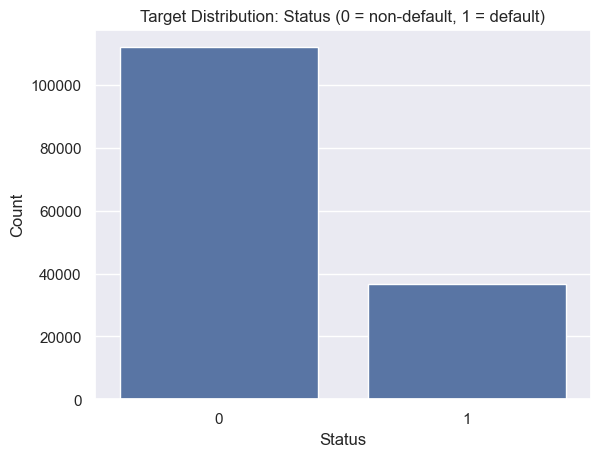

In [5]:
# Assume 'Status' is the target: 0 = non-default, 1 = default
if "Status" not in loan_data.columns:
    raise ValueError("Expected 'Status' column as target but it was not found.")

target_counts = loan_data["Status"].value_counts().sort_index()
target_ratio = loan_data["Status"].value_counts(normalize=True).sort_index()

print("Target distribution (counts):")
display(target_counts)
print("\nTarget distribution (percentage):")
display((target_ratio * 100).round(2))

# Plot
fig, ax = plt.subplots()
sns.barplot(x=target_counts.index, y=target_counts.values, ax=ax)
ax.set_title("Target Distribution: Status (0 = non-default, 1 = default)")
ax.set_xlabel("Status")
ax.set_ylabel("Count")
plt.show()


,Gender,Status,count
0,Female,0,20418
1,Female,1,6848
2,Joint,0,33466
3,Joint,1,7933
4,Male,0,31255
5,Male,1,11091
6,Sex Not Available,0,26892
7,Sex Not Available,1,10767


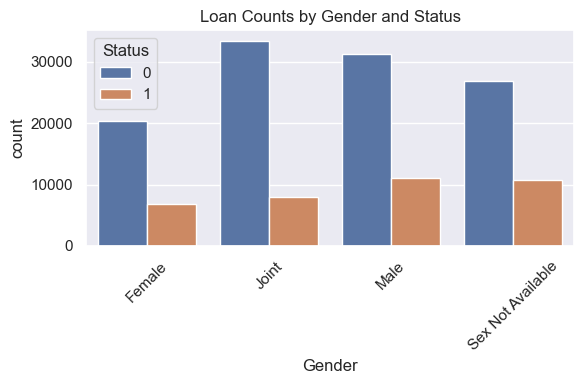

In [6]:
if "Gender" in loan_data.columns:
    gender_status = (
        loan_data.groupby(["Gender", "Status"])
        .size()
        .reset_index(name="count")
    )

    display(gender_status)

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(
        data=gender_status,
        x="Gender", y="count", hue="Status",
        ax=ax
    )
    ax.set_title("Loan Counts by Gender and Status")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


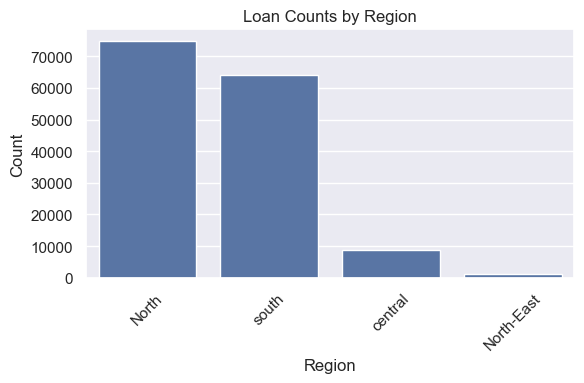

In [7]:
if "Region" in loan_data.columns:
    region_counts = loan_data["Region"].value_counts()

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=region_counts.index, y=region_counts.values, ax=ax)
    ax.set_title("Loan Counts by Region")
    ax.set_xlabel("Region")
    ax.set_ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


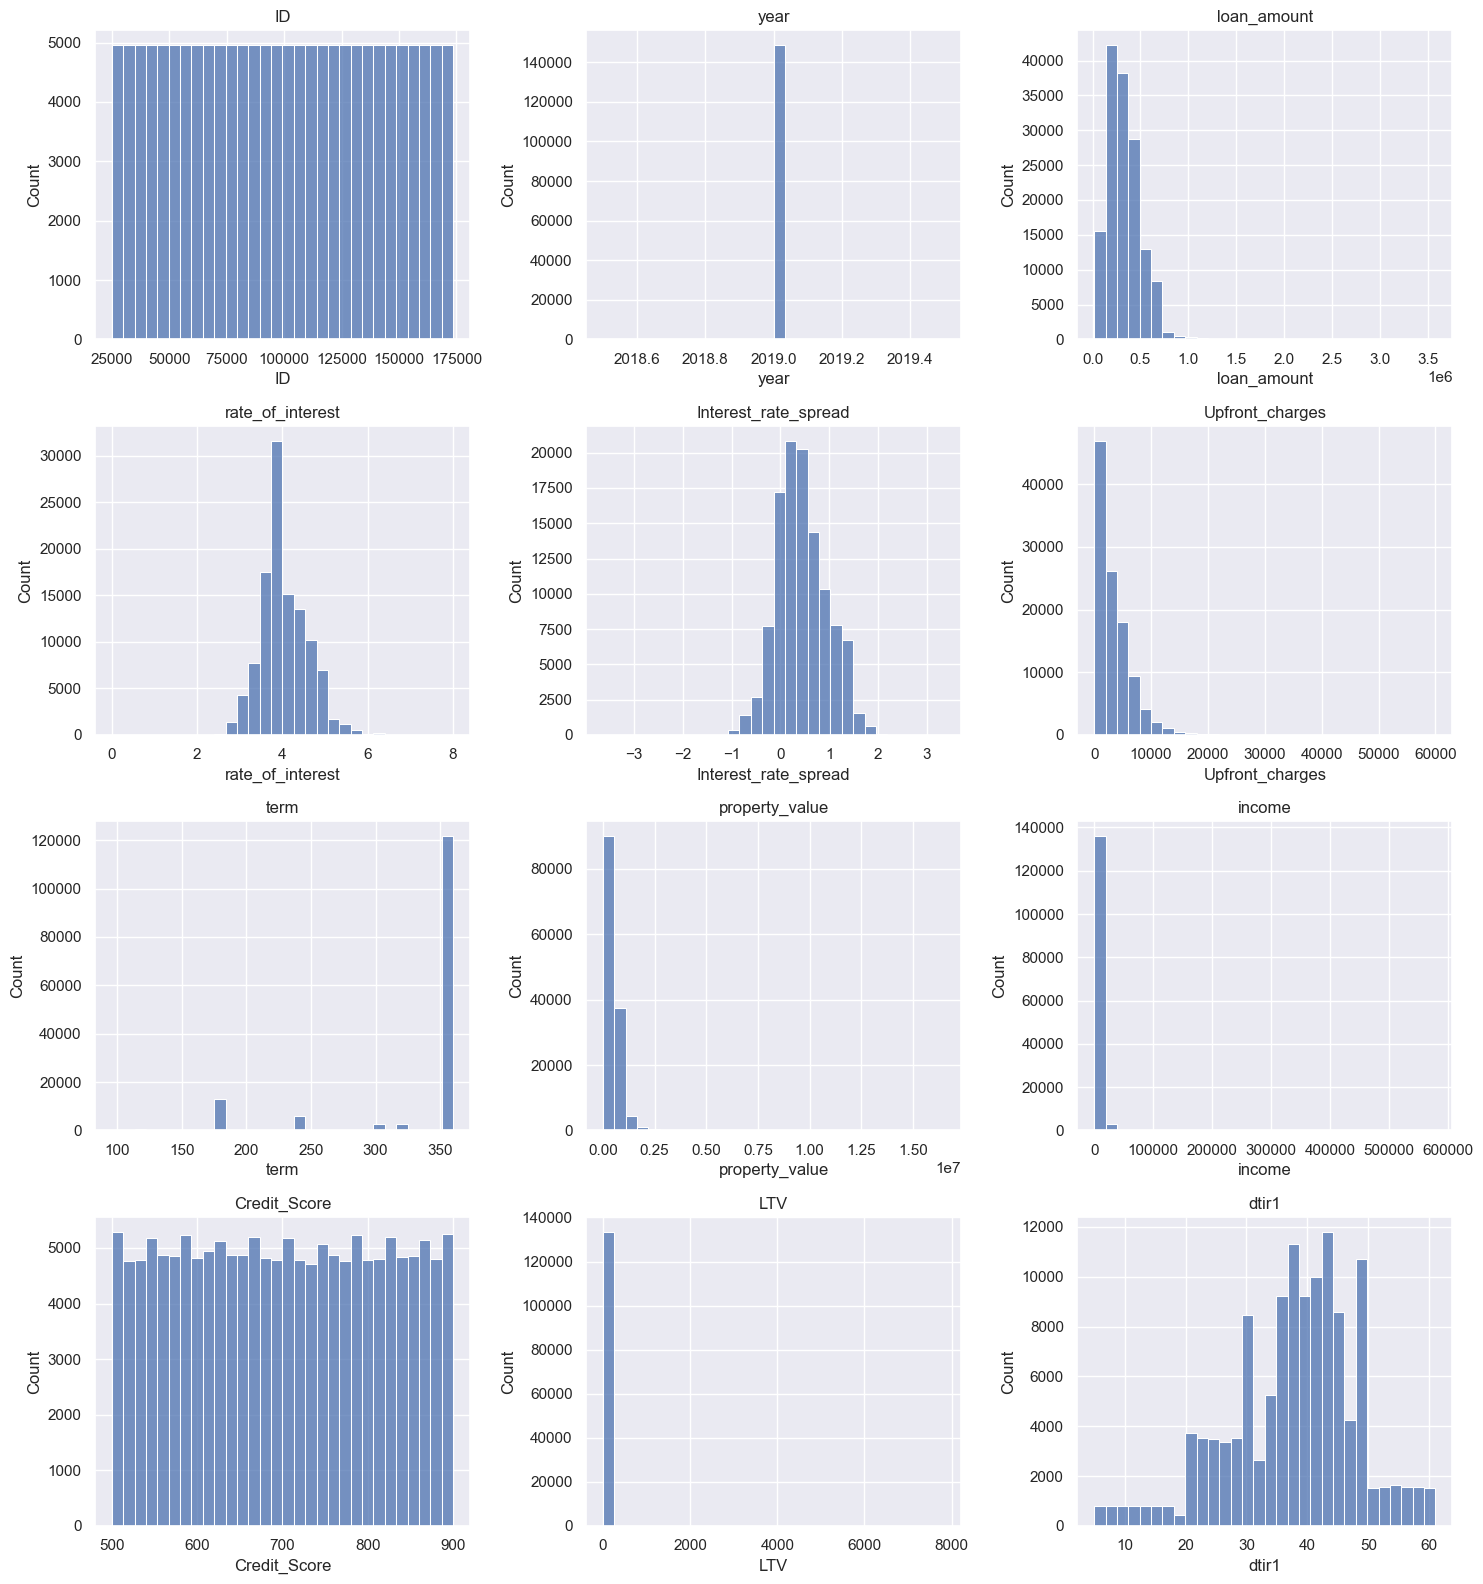

In [8]:
# Choose a subset of important numeric features if you like
# Otherwise, plot all numeric variables
numeric_to_plot = [
    col for col in numeric_cols
    if col != "Status"  # exclude target
]

n_cols = 3
n_rows = int(np.ceil(len(numeric_to_plot) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, numeric_to_plot):
    sns.histplot(loan_data[col].dropna(), bins=30, ax=ax, kde=False)
    ax.set_title(col)

# Hide any unused subplots
for j in range(len(numeric_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


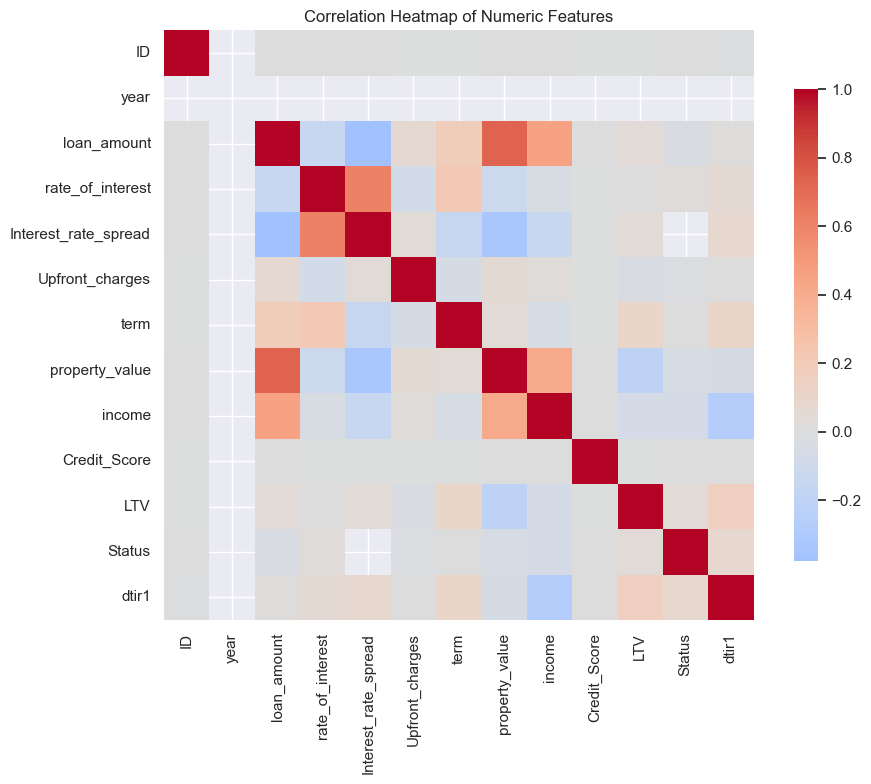

In [9]:
# Correlation among numeric features
corr_matrix = loan_data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


## 5. Outlier Handling and Imputation

To avoid extreme values driving our model behaviour, we implement a simple **z-score based outlier filter** on numeric columns.

Then we:

- Impute numeric missing values with the **mean**.
- Impute categorical missing values with the **mode** (most frequent category).

This is intentionally simple and transparent for a baseline model.


In [10]:
#Removing Irrelevant columns
loan_data.drop(['ID','year','term','Interest_rate_spread','property_value','submission_of_application'],axis=1,inplace=True)

In [11]:


def detect_outliers(data):
    threshold = 3
    for i in data.columns:
        if data[i].dtype=='float64' or data[i].dtype=='int64':
            mean = np.mean(data[i])
            std = np.std(data[i])
            z_scores = [(y - mean) / std for y in data[column]]
            data = data[np.abs(z_scores) <= threshold]
        return data
loan_data = detect_outliers(loan_data)
loan_data



,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,...,1740.0,EXP,758,CIB,25-34,98.728814,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,...,4980.0,EQUI,552,EXP,55-64,NaN,North,direct,1,NaN
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.560,...,9480.0,EXP,834,CIB,35-44,80.019685,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.250,...,11880.0,EXP,587,CIB,45-54,69.376900,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.000,...,10440.0,CRIF,602,EXP,25-34,91.886544,North,direct,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,436500,3.125,...,7860.0,CIB,659,EXP,55-64,71.792763,south,direct,0,48.0
148666,cf,Male,nopre,type1,p1,l1,nopc,nob/c,586500,5.190,...,7140.0,CIB,569,CIB,25-34,74.428934,south,direct,0,15.0
148667,cf,Male,nopre,type1,p4,l1,nopc,nob/c,446500,3.125,...,6900.0,CIB,702,EXP,45-54,61.332418,North,direct,0,49.0
148668,cf,Female,nopre,type1,p4,l1,nopc,nob/c,196500,3.500,...,7140.0,EXP,737,EXP,55-64,70.683453,North,direct,0,29.0


In [12]:

for i in loan_data.columns:       
    if loan_data[i].dtype=='float64' or loan_data[i].dtype=='int64':
        loan_data[i].fillna(loan_data[i].mean(),inplace=True)

    else:
        loan_data[i].fillna(loan_data[i].mode()[0],inplace=True)
        
loan_data.isnull().sum().sum()# Sanity check: no remaining missing values


np.int64(0)

array([[<Axes: title={'center': 'loan_amount'}>,
        <Axes: title={'center': 'rate_of_interest'}>,
        <Axes: title={'center': 'Upfront_charges'}>],
       [<Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'Credit_Score'}>,
        <Axes: title={'center': 'LTV'}>],
       [<Axes: title={'center': 'Status'}>,
        <Axes: title={'center': 'dtir1'}>, <Axes: >]], dtype=object)

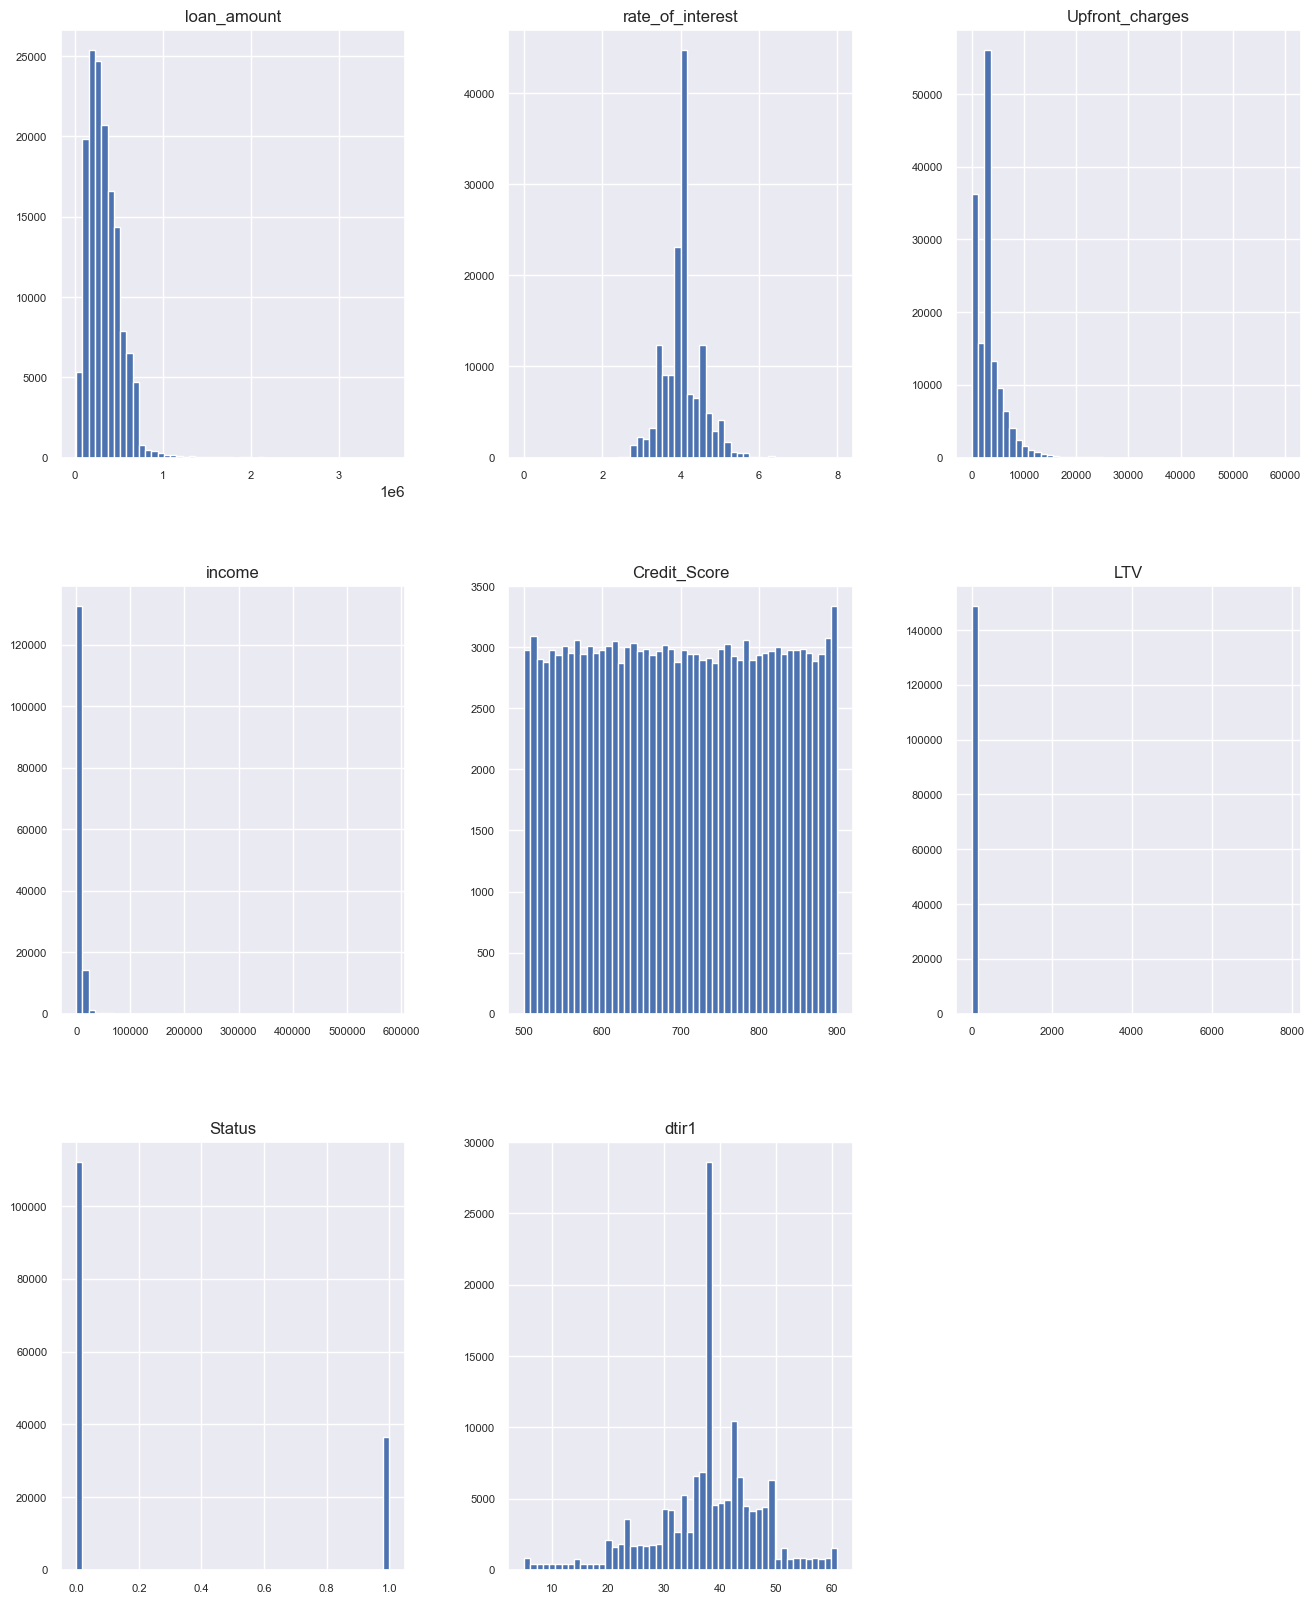

In [13]:
loan_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [14]:
loan_data.to_csv('Preprocessed Data.csv')

## 6. Encoding Categorical Variables

Most machine learning models in scikit-learn require numeric inputs.

For this baseline exercise, we use **label encoding** on all categorical columns.  
This is fine for tree-based models; for linear models, one-hot encoding is usually better, but we keep things simple here.


In [15]:

# Encoding Categorical Variables
categorical_cols =loan_data.select_dtypes(include=['object']).columns
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
loan_data[categorical_cols] = loan_data[categorical_cols].apply(lambda col: le.fit_transform(col))


## 7. Train–Test Split

We now:

- Define **features** `X` (all columns except the target `Status`).
- Define **target** `y` (`Status`).
- Split into **train** and **test** sets (80% / 20%).

We also drop ID-like columns if they exist (for example, `ID`).


In [16]:


#setting target attribute 'Status'
X=loan_data.drop('Status',axis='columns')
Y=loan_data.Status


In [17]:
# Define target and features
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((118936, 27), (29734, 27), (118936,), (29734,))

In [18]:
print("Class balance in full dataset:")
print(loan_data["Status"].value_counts(), "\n")

print("Class balance in y_train:")
print(y_train.value_counts(), "\n")

print("Class balance in y_test:")
print(y_test.value_counts())


Class balance in full dataset:
Status
0    112031
1     36639
Name: count, dtype: int64 

Class balance in y_train:
Status
0    89537
1    29399
Name: count, dtype: int64 

Class balance in y_test:
Status
0    22494
1     7240
Name: count, dtype: int64


## 8. Baseline Classification Models

We train several standard classifiers:

- Logistic Regression  
- K-Nearest Neighbours (KNN)  
- Decision Tree  
- Random Forest  
- Support Vector Machine (SVM)

For each model, we compute:

- **Accuracy**
- **Precision**
- **Recall**
- **F1 score**
- **ROC–AUC** (using predicted probabilities)


In [19]:
# Function to train and evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Get the probability predictions for ROC AUC (only for applicable models)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = np.zeros(len(y_test))
    
    # Evaluate the model using several metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred_proba) if np.any(y_pred_proba) else None
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }

In [ ]:
def run_classification_models(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        # Support Vector Machine': SVC(probability=True)
    }
    
    # Dictionary to store results for each model
    results = {}
    
    # Iterate through each model and evaluate it
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model_results = evaluate_model(model, X_train, y_train, X_test, y_test)
        results[model_name] = model_results
    
    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results).T
    return results_df


results=run_classification_models(X_train, y_train, X_test, y_test)


Model Comparison:
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Training K-Nearest Neighbors...
Training Decision Tree...
Training Random Forest...


In [25]:
results_df = pd.DataFrame(results).sort_values("ROC AUC", ascending=False)
print("\nModel Comparison:")
results_df


Model Comparison:


,Accuracy,Precision,Recall,F1-Score,ROC AUC
Random Forest,0.999966,1.000000,0.999862,0.999931,1.000000
Decision Tree,0.999395,0.998344,0.999171,0.998757,0.999319
K-Nearest Neighbors,0.925002,0.787931,0.946823,0.860100,0.963982
Logistic Regression,0.756508,0.000000,0.000000,0.000000,0.574296


The table above shows baseline performance for each model. 

In a **credit risk** context, we are particularly interested in:

- **Recall**: how many actual defaults we catch  
- **ROC–AUC**: how well we rank accounts by risk  

We may be willing to sacrifice some overall accuracy in order to improve recall for defaults.


## 10. Discussion 

In this notebook we:

- Cleaned the dataset and handled missing values with simple imputation.
- Performed basic EDA:
  - Target imbalance and class distribution
  - Distributions of key numeric features
  - Correlations between variables
- Encoded categorical features and split the data into train and test sets.
- Trained several baseline models:
  - Logistic Regression  
  - KNN  
  - Decision Tree  
  - Random Forest  
- Tabulated and compared them using accuracy, precision, recall, F1, and ROC–AUC.